## import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## define model architecture (p.28 Figure 1.19)

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) # (in channel, out channel, kernel size, stride) ref: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10) # P: probability of an element to be zero-ed. ref: https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html?highlight=dropout2d#torch.nn.Dropout2d
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32. input image should be 12x12.
        self.fc2 = nn.Linear(64, 10) # output is {0,..,9}
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (input, kernel_size. ref: https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html?highlight=max_pool2d#torch.nn.functional.max_pool2d
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [3]:
def train(model, device, train_dataloader, optim, epoch):
    model.train() #  sets the mode to train, not eval.
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad() # use stochastic gradient descent, so reset gradient to 0.
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        
        # print
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [4]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch. ref: https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html
            pred = pred_prob.argmax(dim=1, keepdim=True)  # prediction results for a batch. use argmax to get the most likely prediction. keepdim (bool) – whether the output tensor has dim retained or not.ref: https://pytorch.org/docs/stable/generated/torch.argmax.html
            success += pred.eq(y.view_as(pred)).sum().item() # view_as: View this tensor as the same size as other. ref: https://pytorch.org/docs/stable/generated/torch.Tensor.view_as.html

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


In [30]:
# debug
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred_prob = model(X)
    pred = pred_prob.argmax(dim=1, keepdim=True) 
    print(pred)
    break

tensor([[7],
        [2],
        [1],
        [0],
        [4],
        [1],
        [4],
        [9],
        [5],
        [9],
        [0],
        [6],
        [9],
        [0],
        [1],
        [5],
        [9],
        [7],
        [5],
        [4],
        [9],
        [6],
        [6],
        [5],
        [4],
        [0],
        [7],
        [4],
        [0],
        [1],
        [3],
        [1],
        [3],
        [4],
        [7],
        [2],
        [7],
        [1],
        [2],
        [1],
        [1],
        [7],
        [4],
        [2],
        [3],
        [5],
        [1],
        [2],
        [4],
        [4],
        [6],
        [3],
        [5],
        [5],
        [6],
        [0],
        [4],
        [1],
        [9],
        [5],
        [7],
        [8],
        [9],
        [3],
        [7],
        [4],
        [6],
        [4],
        [3],
        [0],
        [7],
        [0],
        [2],
        [9],
        [1],
        [7],
        [3],

# from here. 2022/8/7

## create data loaders

In [5]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## define optimizer and run training epochs

In [6]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [7]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/home/masahiro/software/anaconda3/envs/study/lib/python3.9/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.301563
epoch: 1 [320/60000 (1%)]	 training loss: 1.999758
epoch: 1 [640/60000 (1%)]	 training loss: 1.404254
epoch: 1 [960/60000 (2%)]	 training loss: 1.206638
epoch: 1 [1280/60000 (2%)]	 training loss: 0.798878
epoch: 1 [1600/60000 (3%)]	 training loss: 0.854381
epoch: 1 [1920/60000 (3%)]	 training loss: 0.916494
epoch: 1 [2240/60000 (4%)]	 training loss: 0.722387
epoch: 1 [2560/60000 (4%)]	 training loss: 1.117116
epoch: 1 [2880/60000 (5%)]	 training loss: 0.958758
epoch: 1 [3200/60000 (5%)]	 training loss: 0.912771
epoch: 1 [3520/60000 (6%)]	 training loss: 0.748333
epoch: 1 [3840/60000 (6%)]	 training loss: 0.910245
epoch: 1 [4160/60000 (7%)]	 training loss: 0.555541
epoch: 1 [4480/60000 (7%)]	 training loss: 0.889906
epoch: 1 [4800/60000 (8%)]	 training loss: 0.994307
epoch: 1 [5120/60000 (9%)]	 training loss: 0.876377
epoch: 1 [5440/60000 (9%)]	 training loss: 0.860759
epoch: 1 [5760/60000 (10%)]	 training loss: 0.770216
epoch: 1 [6080/60

## run inference on trained model

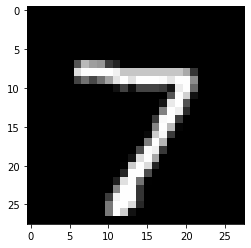

In [8]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [9]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7
